# Credits

This is heavily influenced from https://github.com/pytorch/tutorials

# CIFAR-10

In thins notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.
The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

![cifar10](../static_files/cifar10.png)


In order to train a classifier the following steps needs to be performed:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

We will help you along the way.
We indicate the places you need to modify the code with `# Your code here!`.
It is however a good idea to read the entire assignment before you begin coding!

## 1. Loading and normalizing CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1]

**NB** Modify the code below to only use a small part of the dataset if your computer is very slow.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),
                          (0.5, 0.5, 0.5))]
)

# Load dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
print()

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

used_categories = range(len(classes))

## USE CODE BELOW IF YOUR COMPUTER IS TOO SLOW
reduce_dataset = False
if reduce_dataset:
    used_categories = (3, 5) # cats and dogs

    classes = [classes[i] for i in used_categories]
    new_train_data = []
    new_train_labels = []

    new_test_data = []
    new_test_labels = []
    for i, t in enumerate(used_categories):
        new_train_data.append(trainset.train_data[np.where(np.array(trainset.train_labels) == t)])
        new_train_labels += [i for _ in range(new_train_data[-1].shape[0])]

        new_test_data.append(testset.test_data[np.where(np.array(testset.test_labels) == t)])
        new_test_labels += [i for _ in range(new_test_data[-1].shape[0])]

    new_train_data = np.concatenate(new_train_data, 0)
    trainset.train_data = new_train_data
    trainset.train_labels = new_train_labels

    new_test_data = np.concatenate(new_test_data, 0)
    testset.test_data = new_test_data
    testset.test_labels = new_test_labels

    
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)
train_data_iter = iter(trainloader)
test_data_iter = iter(testloader)
print('used classes:', classes)

Files already downloaded and verified
Files already downloaded and verified

used classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [3]:
print("Training data")
print(trainset.train_data.shape)
print(len(trainset.train_labels))
print()

print("Test data")
print(testset.test_data.shape)
print(len(testset.test_labels))
print()

Training data
(50000, 32, 32, 3)
50000

Test data
(10000, 32, 32, 3)
10000



Let us show some of the training images, for fun.



plane   car   car  ship


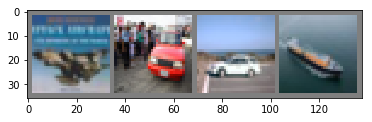

In [4]:
# Run this cell multiple time to see more samples

def imshow(img):
    """ show an image """
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
images, labels = train_data_iter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolutional Neural Network

**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully come back and improve the architecture

In [5]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # in_chan, out_chan, filt_size
        self.pool = nn.MaxPool2d(2, 2) # filter_size, stride, padding
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # in_features, out_features
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 3. Define a Loss function and optimizer

**Assignment 2:** Implement the criterion and optimizer. 
We suggest Classification Cross-Entropy loss and SGD with momentum.
You might need to experiment a bit with the learning rate.

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

## 4. Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 3).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [7]:
num_epoch = 3  # Your code here!

for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

c:\users\kasper\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[1,  1000] loss: 2.269
[1,  2000] loss: 2.053
[1,  3000] loss: 1.915
[1,  4000] loss: 1.780
[1,  5000] loss: 1.709
[1,  6000] loss: 1.619
[1,  7000] loss: 1.587
[1,  8000] loss: 1.550
[1,  9000] loss: 1.531
[1, 10000] loss: 1.480
[1, 11000] loss: 1.465
[1, 12000] loss: 1.436
[2,  1000] loss: 1.378
[2,  2000] loss: 1.403
[2,  3000] loss: 1.374
[2,  4000] loss: 1.384
[2,  5000] loss: 1.364
[2,  6000] loss: 1.356
[2,  7000] loss: 1.339
[2,  8000] loss: 1.310
[2,  9000] loss: 1.315
[2, 10000] loss: 1.264
[2, 11000] loss: 1.296
[2, 12000] loss: 1.295
[3,  1000] loss: 1.232
[3,  2000] loss: 1.226
[3,  3000] loss: 1.223
[3,  4000] loss: 1.222
[3,  5000] loss: 1.213
[3,  6000] loss: 1.189
[3,  7000] loss: 1.179
[3,  8000] loss: 1.219
[3,  9000] loss: 1.220
[3, 10000] loss: 1.211
[3, 11000] loss: 1.201
[3, 12000] loss: 1.220
Finished Training


## 5. Test the network on the test data

Now we need to check if the network has learnt anything at all.
We will check this by predicting the class label that the neural network outputs, and checking it against the ground truth.
If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

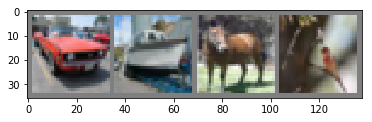

GroundTruth:     car  ship horse  bird
Predicted:       dog truck   dog   cat


In [8]:
images, labels = test_data_iter.next()

# print images
imshow(torchvision.utils.make_grid(images))
plt.show()

print('GroundTruth:  ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

_, predicted = torch.max(outputs.data, 1)
print('Predicted:    ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Let us look at how the network performs on the whole dataset.

In [9]:
correct = 0
total = 0

for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the {} test images: {:4.2f} %'.format(
    testset.test_data.shape[0], 100 * correct / total))

Accuracy of the network on the 10000 test images: 57.00 %


Hopefully the network is better than chance, which is $\frac{1}{\text{number of classes}}$ accuracy (randomly picking
a class).


We can also examine which class the network found the most difficult (makes more sense if you have many clases):

In [10]:
class_total = list(0. for i in range(len(classes)))
class_correct = list(0. for i in range(len(classes)))

for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    
    for i in range(len(c)):
        label = labels[i]
        class_correct[label] += c[i].numpy()
        class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of {:5s} : {:5.2f} %'.format(
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 72.70 %
Accuracy of car   : 73.10 %
Accuracy of bird  : 37.60 %
Accuracy of cat   : 33.60 %
Accuracy of deer  : 60.30 %
Accuracy of dog   : 43.60 %
Accuracy of frog  : 60.40 %
Accuracy of horse : 66.30 %
Accuracy of ship  : 68.00 %
Accuracy of truck : 56.60 %


**Assignment 4:** 
1. Go back and improve performance of the network. 
 * If you are using all 10 classes you should get a test accuracy above 55%, but see how much further you can get it!
 * If you are using only 2 classes (e.g. cat and dog) you should get a test accuracy above 60%, but see how much further you can get it!

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
+
3. Write down key lessons/insights you got (if any) during this exercise

STARTING MODEL:
1. Conv1 layer (in_ch = 3, out_ch = 6, filt_size = 5)
2. Max Pooling (filt_size = 2, stride = 2)
- Conv1 layer (in_ch = 6, out_ch = 16, filt_size = 5)
- Max Pooling (filt_size = 2, stride = 2)
- Fully connected layer (in_feat = 400, out_feat = 120)
- Fully connected layer (in_feat = 120, out_feat = 84)
- Fully connected layer (in_feat = 84, out_feat = 10)


RESULTS
- Performance of first model: 43% acc

First i tried to skip the max pooling. The idea was to preserve image resolution, and thus achieve bette results. 
- Performance with skipped pooling: 44% acc

It had a slight improvement, so i tried skipping the second pooling too.
- Performance with first and second pooling skipped: 47% acc

Since the improvement was so small i tried something else. I tried to change the filter size and make it bigger, thinking that it would pass on outputs based on more information. But this turned out to have a worse performance
- Performance with max pooling and filter size of conv1 sat to 9: 39% acc

Then i tried to make change filter size of max pooling and reduce the filter size of conv1. But this gave me an even worse result.
- Performance with max pooling with filter size 3 and stride 2 AND filter size of conv1 sat to 2: 38% acc

Finally i tried multipling the learning rate by 10 and this gave the best results.
- Performance with lr=0.01 instead of 0.001: 57% acc

I've realized that maxpooling i not reducing the performance that much, compared to what i would have thought. This makes pooling a good way to reduce computation power without losing that much classification accuracy. 

Also reducing or increasing the filter size of the conv layers did'nt improve the model, which suprised me. First i had a theory that makeing the filter size bigger, would improve the model because each ouput pixel of the conv layer would be calculated using more pixels. 

It turned out that the learning rate made THE differnece. I assume that the gradient descent process was taking to "short steps" and never reached a good accuracy given the epochs that was set.


BOOK EXERCISE:
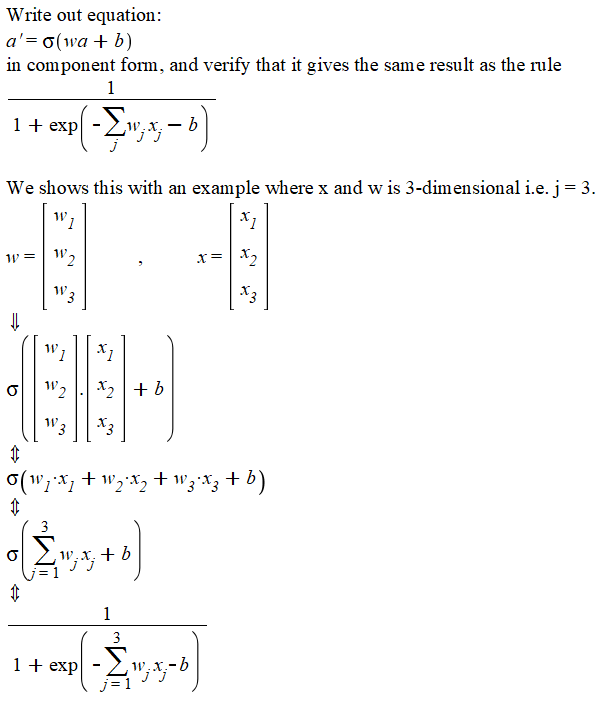

# Training on GPU

**Optional Assignment:**
If you have a GPU we suggest that you try and rewrite the code above to run on the GPU
___

Just like how you transfer a Tensor on to the GPU, you transfer the neural net onto the GPU.
This will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

```
    net.cuda()
```

Remember that you will have to send the inputs and targets at every step to the GPU too:

```
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
```

Why dont I notice MASSIVE speedup compared to CPU? 
Because your network is realllly small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images




# Michael Nielsen book exercise of own choice

**Assignment 5:** Pick an exercise of own choice from [Michael Nielsens book](http://neuralnetworksanddeeplearning.com/)

**Answer:**



